In [1]:
import sys
import os
sys.path.append('C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\python_functions\\jl_nlp_pkg')
sys.path.append('C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\python_functions\\jl_model_explain_pkg')
import nlpbasic.textClean as textClean
import nlpbasic.docVectors as DocVector
import nlpbasic.dataExploration as DataExploration
import nlpbasic.lda as lda
import nlpbasic.tfidf as tfidf

import model_explain.plot as meplot
import model_explain.shap as meshap

from numpy import array,asarray,zeros
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Flatten,Embedding
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import re
pd.set_option('display.max_colwidth', None)
root_path = 'C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\NLP_data'

# Load Data and Basic Exploration

In [2]:
djia_news = pd.read_csv(os.path.join(root_path, "djia_news.csv"))
nasdaq = pd.read_csv(os.path.join(root_path, "nasdaq.csv"))
class_names = ['negative', 'positive','neutral'] #0:neg 1:pos 2:neu

In [3]:
djia_news.head(3)

,Label,Ticker,Headline
0,0,MMM,Employer who stole nearly $3M in wages from 157 workers fined $500
1,1,MMM,Huge new Facebook data leak exposed intimate details of 3m users
2,0,MMM,A campaign has accelerated to turn a disused railway line in Yorkshire into England’s longest cycle tunnel – instead of using £3m of public money to close it for ever. Campaigners say they could enhance West Yorkshire’s health and economy by converting an old railway line.


In [4]:
nasdaq.head(3)

,Label,Ticker,Headline
0,0,A,@TotesTravel : Airline shares tumble as New York imposes quarantine Florida cases spike - An American Airlines Group Inc. plane prepares for landing at LaGuardia Airport (LGA) in New York U.S. on Tuesday April 18... #TravelNewsInsights - https://t.co/6fnJSf3bRh
1,1,A,@TotesTravel : American United call off Hong Kong flights after crew testing rules - An American Airlines Group Inc. Boeing Co. 777-300ER aircraft sits at Hong Kong International Airport in Hong Kong China. Brent... #TravelNewsInsights - https://t.co/mM34IZz6lM
2,0,A,@TotesTravel : U.S. airline stocks hit highest prices since June on travel uptick stimulus hopes - A JetBlue Airways Corp. plane taxis next to American Airlines Group Inc. Delta Air Lines Inc. and Alaska Airlines Inc. aircraft... #TravelNewsInsights - https://t.co/bwxoJDizzN


In [10]:
print('djia_news label',djia_news.Label.value_counts())
print('djia_news data', len(djia_news))
print('djia_news ticker', len(djia_news.Ticker.unique()))
print('----------------')
print('djia_news sample')
print(djia_news.Headline[0])

djia_news label 0    1430
1     936
2      15
Name: Label, dtype: int64
djia_news data 2381
djia_news ticker 29
----------------
djia_news sample
Employer who stole nearly $3M in wages from 157 workers fined $500


In [11]:
print('nasdaq label',nasdaq.Label.value_counts())
print('nasdaq data', len(nasdaq))
print('nasdaq ticker', len(nasdaq.Ticker.unique()))
print('----------------')
print('nasdaq sample')
print(nasdaq.Headline[0])

nasdaq label 0    8565
1    4300
2     316
Name: Label, dtype: int64
nasdaq data 13181
nasdaq ticker 546
----------------
nasdaq sample
@TotesTravel : Airline shares tumble as New York imposes quarantine Florida cases spike - An American Airlines Group Inc. plane prepares for landing at LaGuardia Airport (LGA) in New York U.S. on Tuesday April 18... #TravelNewsInsights - https://t.co/6fnJSf3bRh


# NLP Exploration

In [16]:
djia_tokens = textClean.pipeline(djia_news['Headline'].to_list(), multi_gram = [1], lower_case=True, deacc=False, 
                                 encoding='utf8', errors='strict', stem_lemma = 'lemma', tag_drop = ['V'], nltk_stop=True, 
                                 stop_word_list=[], remove_pattern = [], check_numbers=True, word_length=2, 
                                 remove_consecutives=True)

In [17]:
nasdaq_tokens = textClean.pipeline(djia_news['Headline'].to_list(), multi_gram = [1], lower_case=True, deacc=False, 
                                 encoding='utf8', errors='strict', stem_lemma = 'lemma', tag_drop = ['V'], nltk_stop=True, 
                                 stop_word_list=[], remove_pattern = ['http:','#', '@'], check_numbers=True, word_length=2, 
                                 remove_consecutives=True)

In [23]:
top_10_freq_words = [i[0] for i in DataExploration.get_topn_freq_bow(djia_tokens, topn = 10)]
print('top 10 frequent words', top_10_freq_words)
top30tfidf = tfidf.get_top_n_tfidf_bow(djia_tokens, top_n_tokens = 30)
print('top 30 tfidf', top30tfidf)
no_topics = 10
lda_allbow, bow_corpus, dictionary = lda.fit_lda(djia_tokens, num_topics = no_topics)
lda.lda_topics(lda_allbow)

top 10 frequent words ['apple', 'company', 'amp', 'microsoft', 'american', 'billion', 'home', 'visa', 'china', 'chevron']
top 30 tfidf ['visa', 'caterpillar', 'salesforce', 'world', 'italy', 'dow', 'low', 'agreement', 'cancer', 'mask', 'boeing', 'thermostat', 'goldman', 'nike', 'ibm', 'india', 'dead', 'disney', 'owner', 'microsoft', 'security', 'mcdonalds', 'company', 'crash', 'walmart', 'walgreens', 'cloud', 'online', 'de', 'office']


,Topics,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10
0,1,american,express,ibm,home,market,company,mcdonalds,billion,technology,employee
1,2,dow,point,china,salesforce,million,walgreens,morgan,caterpillar,merck,chase
2,3,johnson,court,boris,chevron,amp,country,procter,gamble,visa,brexit
3,4,salesforce,chevron,apple,nike,home,billion,depot,american,intel,express
4,5,disney,nike,goldman,russian,sachs,world,coca,walmart,cola,company
5,6,goldman,apple,caterpillar,sachs,bank,new,american,merck,global,report
6,7,walmart,home,depot,american,microsoft,express,worker,company,ibm,profit
7,8,microsoft,johnson,boris,visa,trump,caterpillar,worker,new,uk,nike
8,9,coca,cola,traveler,ibm,inc,intel,water,chinese,government,china
9,10,trump,intel,company,amp,apple,china,chevron,disney,dow,system


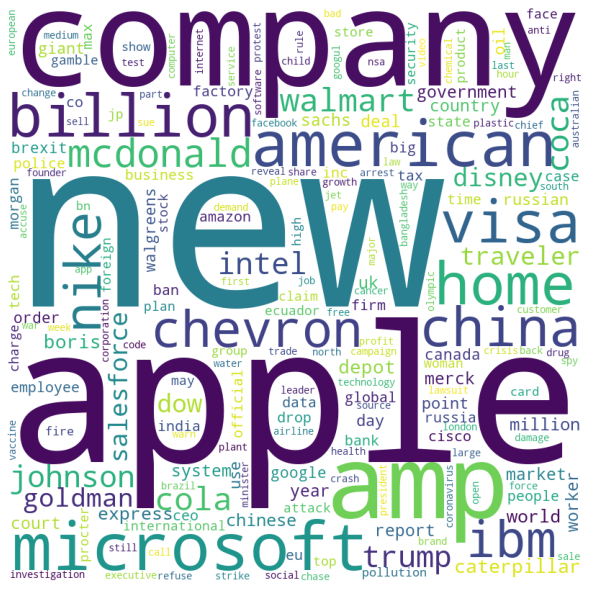

In [20]:
DataExploration.generate_word_cloud(djia_tokens)

In [24]:
top_10_freq_words = [i[0] for i in DataExploration.get_topn_freq_bow(nasdaq_tokens, topn = 10)]
print('top 10 frequent words', top_10_freq_words)
top30tfidf = tfidf.get_top_n_tfidf_bow(nasdaq_tokens, top_n_tokens = 30)
print('top 30 tfidf', top30tfidf)
no_topics = 10
lda_allbow, bow_corpus, dictionary = lda.fit_lda(nasdaq_tokens, num_topics = no_topics)
lda.lda_topics(lda_allbow)

top 10 frequent words ['apple', 'company', 'amp', 'microsoft', 'billion', 'american', 'visa', 'china', 'home', 'chevron']
top 30 tfidf ['visa', 'salesforce', 'mcdonalds', 'dead', 'mask', 'security', 'crash', 'goldman', 'company', 'walmart', 'nike', 'walgreens', 'thermostat', 'world', 'caterpillar', 'ibm', 'cancer', 'boeing', 'italy', 'owner', 'india', 'agreement', 'low', 'disney', 'microsoft', 'dow', 'cloud', 'online', 'de', 'office']


,Topics,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10
0,1,american,billion,chevron,express,company,intel,nike,china,tax,apple
1,2,walmart,salesforce,china,walgreens,merck,nike,million,chevron,chase,apple
2,3,johnson,visa,boris,amp,nike,gamble,country,procter,court,world
3,4,apple,salesforce,intel,coca,cola,microsoft,billion,google,anti,share
4,5,disney,microsoft,court,goldman,russian,company,apple,people,ibm,billion
5,6,goldman,sachs,caterpillar,bank,report,american,new,express,global,ibm
6,7,home,depot,apple,american,mcdonalds,company,trump,microsoft,express,dow
7,8,johnson,boris,walmart,visa,amp,worker,depot,home,new,uk
8,9,traveler,microsoft,china,ibm,caterpillar,coca,cola,chinese,government,system
9,10,merck,company,amp,trump,disney,chevron,home,report,nike,new


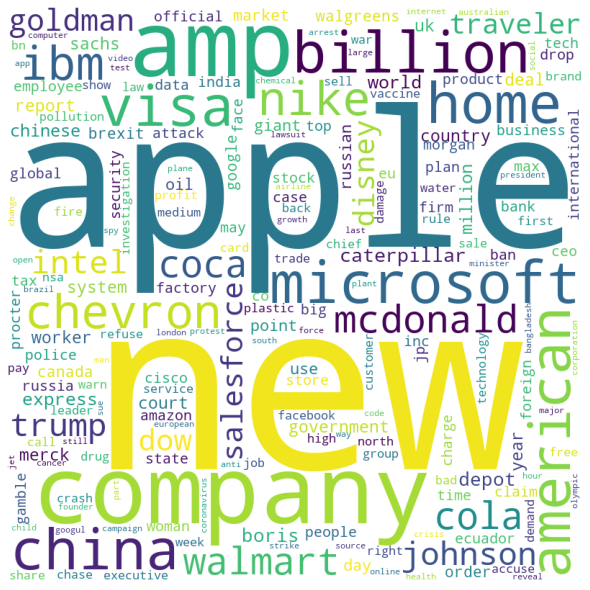

In [25]:
DataExploration.generate_word_cloud(nasdaq_tokens)